In [ ]:
# default_exp metrics

In [ ]:
#all_slow

# Metrics
> Classes and functions for calculating and plotting metrics.

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [ ]:
#export
from lemonpie.basics import * 
from fastai.imports import *
from sklearn import metrics as skl_metrics, preprocessing as skl_preproc

In [ ]:
#hide
from nbdev.showdoc import *

**First defining some test data**

In [ ]:
y = torch.tensor((0,1,0,1,0)).unsqueeze(1)
yhat = torch.tensor((.1,.8,.49,.53,.6)).unsqueeze(1)

In [ ]:
y.dtype, yhat.dtype

(torch.int64, torch.float32)

And some multi-label (multi-task) test data

In [ ]:
yhat_mt = torch.rand(10,4)
yhat_mt

tensor([[0.3137, 0.7057, 0.8091, 0.6279],
        [0.0104, 0.9387, 0.2502, 0.6880],
        [0.2544, 0.0550, 0.6559, 0.1570],
        [0.5806, 0.3732, 0.9301, 0.9665],
        [0.2598, 0.8693, 0.7225, 0.9324],
        [0.0742, 0.7114, 0.7245, 0.1057],
        [0.1661, 0.9369, 0.6056, 0.0246],
        [0.4413, 0.2379, 0.3213, 0.8767],
        [0.0652, 0.1064, 0.9167, 0.0079],
        [0.4280, 0.9548, 0.9420, 0.8374]])

In [ ]:
y_mt = torch.randint(2, yhat_mt.shape)
y_mt

tensor([[0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 0, 1, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [0, 1, 1, 0],
        [0, 1, 1, 0],
        [1, 1, 1, 1]])

## Simple Accuracies

In [ ]:
#export
def accuracy(y:'y_true', yhat:'yhat_prob', threshold:float=0.5) -> float:
    '''Accuracy (percentage of correct predictions) for binary classification'''
    return ((yhat > 0.5) == y).float().mean()

In [ ]:
#export
def null_accuracy(y:'y_true') -> float:
    '''Null accuracy for binary classification: accuracy that could be achieved by always predicting the most frequent class'''
    null_mean = y.float().mean()
    return max(null_mean, 1-null_mean)

In [ ]:
accuracy(y, yhat), null_accuracy(y)

(tensor(0.8000), tensor(0.6000))

In [ ]:
accuracy(y_mt, yhat_mt), null_accuracy(y_mt)

(tensor(0.4750), tensor(0.5000))

## ROC Curve & Optimal Threshold

In [ ]:
y.shape, yhat.shape, y_mt.shape, yhat_mt.shape

(torch.Size([5, 1]),
 torch.Size([5, 1]),
 torch.Size([10, 4]),
 torch.Size([10, 4]))

### Class `ROC` + Optimal Threshold -

- To use @ inference time for cutoff of yhat
- [From these explanations](https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python)
- Not implementing Youden's J-Score, but thats another option too - also in the above link

In [ ]:
#export
class ROC:
    '''Class to hold Receiver Operating Characteristic (ROC) and AUROC (area under ROC curve) score for a single class'''
    def __init__(self, y, yhat):
        self.fpr, self.tpr, self.thresholds = skl_metrics.roc_curve(y, yhat)
        self.auroc = skl_metrics.roc_auc_score(y, yhat)
    
    def optimal_thresh(self):
        '''Calculate optimal threshold (on ROC curve) for a single class'''
        opt_idx = np.argmin(np.sqrt(np.square(1-self.tpr) + np.square(self.fpr)))
        return self.thresholds[opt_idx]
    
    def plot(self, label, title):
        '''Plot ROC curve for a single class'''
        plot_rocs([self], labels=[label], title=title)

In [ ]:
show_doc(ROC, title_level=3)

<h3 id="ROC" class="doc_header"><code>class</code> <code>ROC</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>ROC</code>(**`y`**, **`yhat`**)

Class to hold Receiver Operating Characteristic (ROC) and AUROC (area under ROC curve) score for a single class

In [ ]:
show_doc(ROC.optimal_thresh)

<h4 id="ROC.optimal_thresh" class="doc_header"><code>ROC.optimal_thresh</code><a href="__main__.py#L8" class="source_link" style="float:right">[source]</a></h4>

> <code>ROC.optimal_thresh</code>()

Calculate optimal threshold (on ROC curve) for a single class

In [ ]:
show_doc(ROC.plot)

<h4 id="ROC.plot" class="doc_header"><code>ROC.plot</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>ROC.plot</code>(**`label`**, **`title`**)

Plot ROC curve for a single class

**Test**

In [ ]:
test_roc = ROC(y, yhat)

In [ ]:
test_roc.fpr, test_roc.tpr, test_roc.thresholds, test_roc.optimal_thresh(), test_roc.auroc

(array([0.        , 0.        , 0.33333333, 0.33333333, 1.        ]),
 array([0. , 0.5, 0.5, 1. , 1. ]),
 array([1.8 , 0.8 , 0.6 , 0.53, 0.1 ], dtype=float32),
 0.53,
 0.8333333333333334)

### Class `MultiLabelROC` - 

In [ ]:
#export
class MultiLabelROC:
    '''Class that holds `ROC` objects for multiple classes'''
    def __init__(self, y, yhat, labels):
        self.labels = labels
        self.ROCs = dict()
        for i in range(len(labels)):
            self.ROCs[labels[i]] = ROC(y[:, i], yhat[:, i])
            
    def plot(self, title):
        '''Plot multiple ROC curves in a single plot'''
        plot_rocs(self.ROCs, labels=self.labels, title=title, multilabel=True)

In [ ]:
show_doc(MultiLabelROC, title_level=3)

<h3 id="MultiLabelROC" class="doc_header"><code>class</code> <code>MultiLabelROC</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>MultiLabelROC</code>(**`y`**, **`yhat`**, **`labels`**)

Class that holds [`ROC`](/lemonpie/metrics.html#ROC) objects for multiple classes

In [ ]:
show_doc(MultiLabelROC.plot)

<h4 id="MultiLabelROC.plot" class="doc_header"><code>MultiLabelROC.plot</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>MultiLabelROC.plot</code>(**`title`**)

Plot multiple ROC curves in a single plot

**Test**

In [ ]:
LABELS

['diabetes', 'stroke', 'alzheimers', 'coronaryheart']

In [ ]:
y_mt.shape, yhat_mt.shape

(torch.Size([10, 4]), torch.Size([10, 4]))

In [ ]:
mt_rocs = MultiLabelROC(y_mt, yhat_mt, LABELS)

In [ ]:
mt_rocs.ROCs['diabetes'].fpr, mt_rocs.ROCs['diabetes'].tpr, mt_rocs.ROCs['diabetes'].thresholds, \
mt_rocs.ROCs['diabetes'].optimal_thresh(), mt_rocs.ROCs['diabetes'].auroc

(array([0. , 0. , 0.2, 0.2, 0.4, 0.4, 0.6, 0.6, 1. ]),
 array([0. , 0.2, 0.2, 0.4, 0.4, 0.6, 0.6, 1. , 1. ]),
 array([1.580641  , 0.5806411 , 0.44134134, 0.42800868, 0.31371653,
        0.25979996, 0.2543732 , 0.07419437, 0.01037359], dtype=float32),
 0.25979996,
 0.64)

In [ ]:
mt_rocs.ROCs['stroke'].fpr, mt_rocs.ROCs['stroke'].tpr, mt_rocs.ROCs['stroke'].thresholds, \
mt_rocs.ROCs['stroke'].optimal_thresh(), mt_rocs.ROCs['stroke'].auroc

(array([0., 0., 1., 1.]),
 array([0. , 0.2, 0.2, 1. ]),
 array([1.9547961 , 0.954796  , 0.7056961 , 0.05504644], dtype=float32),
 0.954796,
 0.2)

## Plot

In [ ]:
#export
def plot_rocs(ROCs, labels, title='ROC curve', multilabel=False, axis=None):
    '''Plot one (single-label) or multiple (multi-label) ROC curves'''
    if axis == None:
        fig = plt.figure(figsize=(8,5))
        axis = fig.add_axes([0,0,1,1])
    for i in range(len(ROCs)):
        if multilabel: axis.plot(ROCs[labels[i]].fpr, ROCs[labels[i]].tpr, label=f'{labels[i]} - {ROCs[labels[i]].auroc:0.3f}')
        else: axis.plot(ROCs[i].fpr, ROCs[i].tpr, label=f'{labels[i]} - {ROCs[i].auroc:0.3f}')
    axis.set_xlim([0.0, 1.0])
    axis.set_ylim([0.0, 1.0])
    axis.set_title(title)
    axis.set_xlabel('False Positive Rate (1 - Specificity)')
    axis.set_ylabel('True Positive Rate (Sensitivity)')
    axis.legend(loc="lower right")
    axis.grid(True)

In [ ]:
#export
def plot_train_valid_rocs(train_ROC, valid_ROC, labels, multilabel=False):
    '''Convenience fn to plot train and valid ROC curves side by side'''
    if multilabel:
        fig, axes = plt.subplots(1,2, figsize=(15,5))
        plt.tight_layout()
        plot_rocs(train_ROC, labels, title='Train ROC curves', multilabel=True, axis=axes[0])
        plot_rocs(valid_ROC, labels, title='Valid ROC curves', multilabel=True, axis=axes[1])
    else:
        plot_rocs([train_ROC, valid_ROC], ['train', 'valid'], title='Train & Valid ROC Curves')

**Test**

In [ ]:
yhat_train=torch.rand(64,1)
yhat_valid=torch.rand(64,1)
y_train = torch.randint(2, yhat_train.shape)
y_valid = torch.randint(2, yhat_valid.shape)

In [ ]:
yhat_train_mt = torch.rand(64,4)
yhat_valid_mt = torch.rand(64,4)
y_train_mt = torch.randint(2, yhat_train_mt.shape)
y_valid_mt = torch.randint(2, yhat_valid_mt.shape)

In [ ]:
train_mt_rocs = MultiLabelROC(y_train_mt, yhat_train_mt, LABELS)
valid_mt_rocs = MultiLabelROC(y_valid_mt, yhat_valid_mt, LABELS)

In [ ]:
train_roc = ROC(y_train, yhat_train)
valid_roc = ROC(y_valid, yhat_valid)

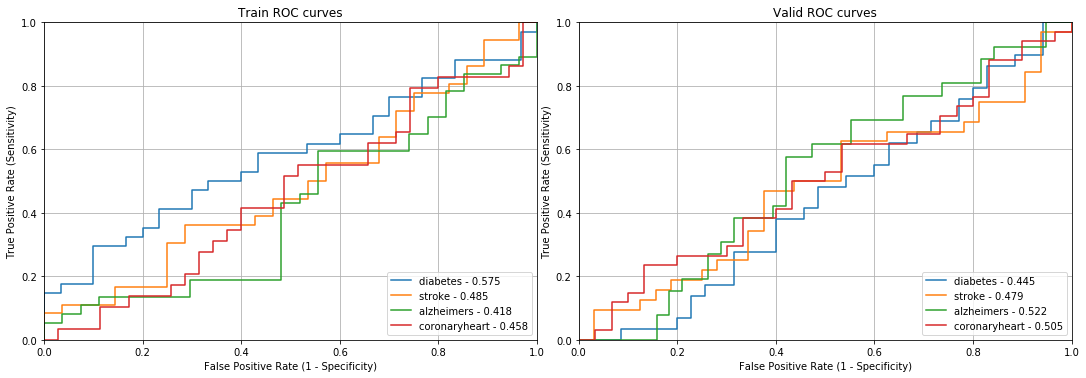

In [ ]:
plot_train_valid_rocs(train_mt_rocs.ROCs, valid_mt_rocs.ROCs, LABELS, multilabel=True)

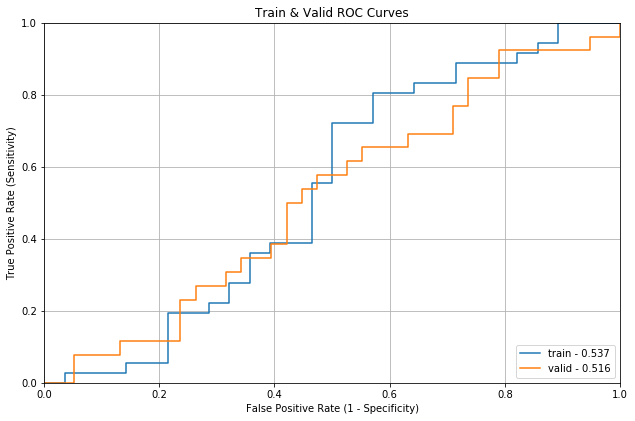

In [ ]:
plot_train_valid_rocs(train_roc, valid_roc, LABELS, multilabel=False) #LABELS ignored

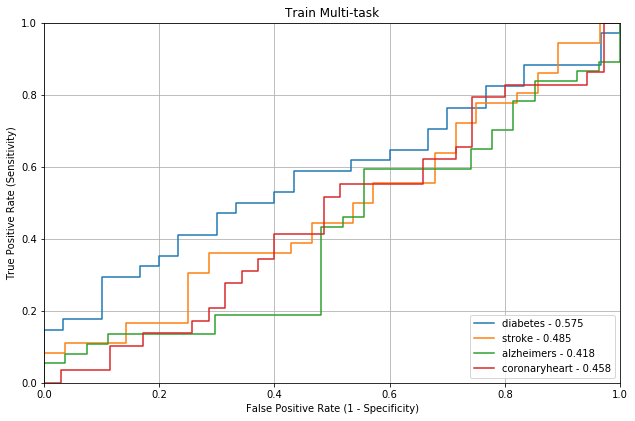

In [ ]:
plot_rocs(train_mt_rocs.ROCs, LABELS, title='Train Multi-task', multilabel=True)

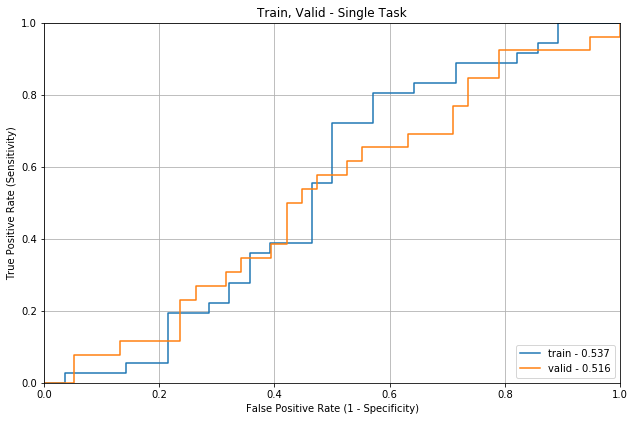

In [ ]:
plot_rocs([train_roc, valid_roc], ['train','valid'], title='Train, Valid - Single Task')

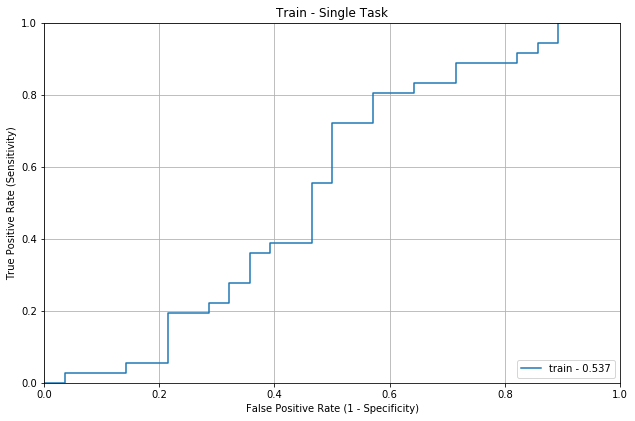

In [ ]:
plot_rocs([train_roc], ['train'], title='Train - Single Task')

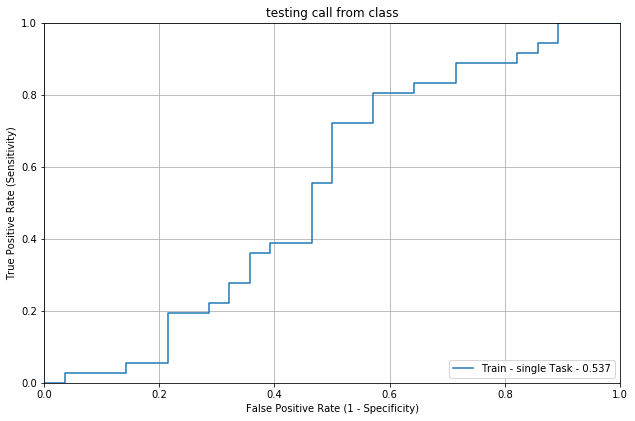

In [ ]:
train_roc.plot('Train - single Task', 'testing call from class')

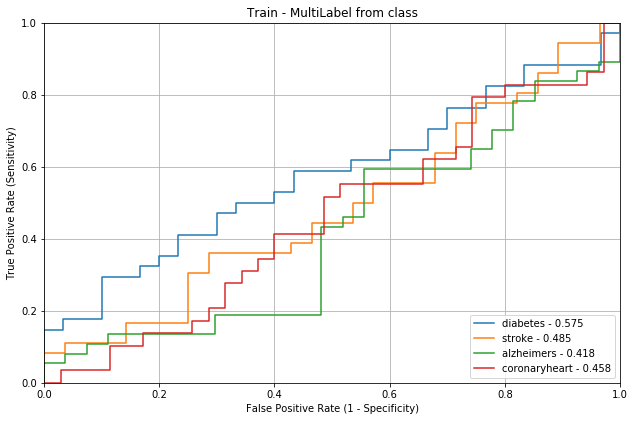

In [ ]:
train_mt_rocs.plot('Train - MultiLabel from class')

## AUROC Score & Confidence Interval

### AUROC Score

In [ ]:
#export
def auroc_score(y, yhat, average=None):
    '''Return scikit_learn auroc score'''
    return skl_metrics.roc_auc_score(y, yhat, average=average)

In [ ]:
yhat_mt = torch.rand(64,4)
y_mt = torch.randint(2,size=(64,4))
# y_mt, yhat_mt

In [ ]:
print("average=weighted: ",skl_metrics.roc_auc_score(y_mt, yhat_mt, average='weighted'))
print("average=macro: ",skl_metrics.roc_auc_score(y_mt, yhat_mt))
print("average=micro: ",skl_metrics.roc_auc_score(y_mt, yhat_mt, average='micro'))
print("average=none: ",skl_metrics.roc_auc_score(y_mt, yhat_mt, average=None))
print("acc: ", accuracy(y_mt, yhat_mt))
print("null acc: ", null_accuracy(y_mt))

average=weighted:  0.4879348513598988
average=macro:  0.4870098039215687
average=micro:  0.4809995112414467
average=none:  [0.55882353 0.51568627 0.53137255 0.34215686]
acc:  tensor(0.4727)
null acc:  tensor(0.5156)


In [ ]:
aurocs = []
for label in range (y_mt.shape[1]):
    aurocs.append(skl_metrics.roc_auc_score(y_mt[:,label], yhat_mt[:,label]))
print("aurocs: ", aurocs)
print("np.mean of aurocs: ", np.mean(aurocs))

aurocs:  [0.5588235294117647, 0.5156862745098039, 0.5313725490196078, 0.3421568627450981]
np.mean of aurocs:  0.4870098039215687


So ...
- **`average=None` ==> calling individually**
- **`average=macro` ==> mean of individual calls**

In [ ]:
skl_metrics.roc_auc_score(y_mt, yhat_mt, average=None) == aurocs # None
skl_metrics.roc_auc_score(y_mt, yhat_mt) == np.mean(aurocs) #macro

True

### Confidence Interval
- Based on [this explanation](https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals)
- This is the bootstrapping method not the DeLong method

In [ ]:
#export
def auroc_ci(y, yhat):
    '''Returns 95% confidence interval for auroc'''
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y), len(y))
        if len(np.unique(y[indices])) < 2: continue   # reject this sample
        score = skl_metrics.roc_auc_score(y[indices], yhat[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return round(confidence_lower,3), round(confidence_upper,3)

In [ ]:
y_pred = np.array([0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04])
y_true = np.array([0,    1,    0,    0,    1,    1,    0,    1,    0   ])

In [ ]:
auroc_score(y_true, y_pred), auroc_ci(y_true, y_pred)

(0.8, (0.389, 1.0))

In [ ]:
auroc_score(y_mt, yhat_mt)

array([0.55882353, 0.51568627, 0.53137255, 0.34215686])

## Wrapper -

In [ ]:
#hide
def ehr_accuracies(yb, yhat):
    '''Returns classification accuracy and auroc score for binary classification'''
    return accuracy(yb, yhat), auroc_score(yb, yhat, average=None)

In [ ]:
#hide
(yhat>.5).float(), y

(tensor([[0.],
         [1.],
         [0.],
         [1.],
         [1.]]), tensor([[0],
         [1],
         [0],
         [1],
         [0]]))

In [ ]:
#hide
ehr_accuracies(y, yhat)

(tensor(0.8000), 0.8333333333333334)

In [ ]:
#hide
y_mt.shape, yhat_mt.shape

(torch.Size([64, 4]), torch.Size([64, 4]))

In [ ]:
#hide
ehr_accuracies(y_mt, yhat_mt)

(tensor(0.4727), array([0.55882353, 0.51568627, 0.53137255, 0.34215686]))

## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_basics.ipynb.
Converted 01_preprocessing_clean.ipynb.
Converted 02_preprocessing_vocab.ipynb.
Converted 03_preprocessing_transform.ipynb.
Converted 04_data.ipynb.
Converted 05_metrics.ipynb.
Converted 06_learn.ipynb.
Converted 07_models.ipynb.
Converted 08_experiment.ipynb.
Converted 99_quick_walkthru.ipynb.
Converted 99_running_exps.ipynb.
Converted index.ipynb.
